In [21]:
import os
import re
import numpy as np
import time
import random
import pandas as pd
import glob
import shutil
import seaborn as sns
import itertools
import math
from pathlib import Path
import json
from copy import deepcopy
from dataclasses import dataclass
from types import SimpleNamespace

from matplotlib.lines import Line2D
from scipy.integrate import solve_ivp
from sklearn.metrics import confusion_matrix
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks
from autocatalytic_cores_lib import *
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import newton_krylov
from scipy.optimize import broyden1
from scipy.optimize import anderson
from scipy.optimize._nonlin import NoConvergence
from sympy import symbols, Matrix, diff, lambdify
from scipy.linalg import eigvals
from numpy.linalg import svd
from scipy.optimize import linprog
from scipy.sparse import csr_matrix
from scipy.sparse import bmat
from scipy.sparse.csgraph import connected_components
from scipy.linalg import eigh
from scipy.optimize import fsolve
from textwrap import dedent
import networkx as nx   
from matplotlib import animation

In [2]:
class Neumann(object):

    """
    This class describes the Generalized von Neumann growth model as it was
    discussed in Kemeny et al. (1956, ECTA) and Gale (1960, Chapter 9.5):

    Let:
    n ... number of goods
    m ... number of activities
    A ... input matrix is m-by-n
        a_{i,j} - amount of good j consumed by activity i
    B ... output matrix is m-by-n
        b_{i,j} - amount of good j produced by activity i

    x ... intensity vector (m-vector) with non-negative entries
        x'B - the vector of goods produced
        x'A - the vector of goods consumed
    p ... price vector (n-vector) with non-negative entries
        Bp - the revenue vector for every activity
        Ap - the cost of each activity

    Both A and B have non-negative entries. Moreover, we assume that
    (1) Assumption I (every good which is consumed is also produced):
        for all j, b_{.,j} > 0, i.e. at least one entry is strictly positive
    (2) Assumption II (no free lunch):
        for all i, a_{i,.} > 0, i.e. at least one entry is strictly positive

    Parameters
    ----------
    A : array_like or scalar(float)
        Part of the state transition equation.  It should be `n x n`
    B : array_like or scalar(float)
        Part of the state transition equation.  It should be `n x k`
    """

    def __init__(self, A, B):

        self.A, self.B = list(map(self.convert, (A, B)))
        self.m, self.n = self.A.shape

        # Check if (A, B) satisfy the basic assumptions
        assert self.A.shape == self.B.shape, 'The input and output matrices \
              must have the same dimensions!'
        assert (self.A >= 0).all() and (self.B >= 0).all(), 'The input and \
              output matrices must have only non-negative entries!'

        # (1) Check whether Assumption I is satisfied:
        if (np.sum(B, 0) <= 0).any():
            self.AI = False
        else:
            self.AI = True

        # (2) Check whether Assumption II is satisfied:
        if (np.sum(A, 1) <= 0).any():
            self.AII = False
        else:
            self.AII = True

    def __repr__(self):
        return self.__str__()

    def __str__(self):

        me = """
        Generalized von Neumann expanding model:
          - number of goods          : {n}
          - number of activities     : {m}

        Assumptions:
          - AI:  every column of B has a positive entry    : {AI}
          - AII: every row of A has a positive entry       : {AII}

        """
        # Irreducible                                       : {irr}
        return dedent(me.format(n=self.n, m=self.m,
                                AI=self.AI, AII=self.AII))

    def convert(self, x):
        """
        Convert array_like objects (lists of lists, floats, etc.) into
        well-formed 2D NumPy arrays
        """
        return np.atleast_2d(np.asarray(x))


    def bounds(self):
        """
        Calculate the trivial upper and lower bounds for alpha (expansion rate)
        and beta (interest factor). See the proof of Theorem 9.8 in Gale (1960)
        """

        n, m = self.n, self.m
        A, B = self.A, self.B

        f = lambda α: ((B - α * A) @ np.ones((n, 1))).max()
        g = lambda β: (np.ones((1, m)) @ (B - β * A)).min()

        UB = fsolve(f, 1).item()  # Upper bound for α, β
        LB = fsolve(g, 2).item()  # Lower bound for α, β

        return LB, UB


    def zerosum(self, γ, dual=False):
        """
        Given gamma, calculate the value and optimal strategies of a
        two-player zero-sum game given by the matrix

                M(gamma) = B - gamma * A

        Row player maximizing, column player minimizing

        Zero-sum game as an LP (primal --> α)

            max (0', 1) @ (x', v)
            subject to
            [-M', ones(n, 1)] @ (x', v)' <= 0
            (x', v) @ (ones(m, 1), 0) = 1
            (x', v) >= (0', -inf)

        Zero-sum game as an LP (dual --> beta)

            min (0', 1) @ (p', u)
            subject to
            [M, -ones(m, 1)] @ (p', u)' <= 0
            (p', u) @ (ones(n, 1), 0) = 1
            (p', u) >= (0', -inf)

        Outputs:
        --------
        value: scalar
            value of the zero-sum game

        strategy: vector
            if dual = False, it is the intensity vector,
            if dual = True, it is the price vector
        """

        A, B, n, m = self.A, self.B, self.n, self.m
        M = B - γ * A

        if dual == False:
            # Solve the primal LP (for details see the description)
            # (1) Define the problem for v as a maximization (linprog minimizes)
            c = np.hstack([np.zeros(m), -1])

            # (2) Add constraints :
            # ... non-negativity constraints
            bounds = tuple(m * [(0, None)] + [(None, None)])
            # ... inequality constraints
            A_iq = np.hstack([-M.T, np.ones((n, 1))])
            b_iq = np.zeros((n, 1))
            # ... normalization
            A_eq = np.hstack([np.ones(m), 0]).reshape(1, m + 1)
            b_eq = 1

            res = linprog(c, A_ub=A_iq, b_ub=b_iq, A_eq=A_eq, b_eq=b_eq,
                          bounds=bounds)

        else:
            # Solve the dual LP (for details see the description)
            # (1) Define the problem for v as a maximization (linprog minimizes)
            c = np.hstack([np.zeros(n), 1])

            # (2) Add constraints :
            # ... non-negativity constraints
            bounds = tuple(n * [(0, None)] + [(None, None)])
            # ... inequality constraints
            A_iq = np.hstack([M, -np.ones((m, 1))])
            b_iq = np.zeros((m, 1))
            # ... normalization
            A_eq = np.hstack([np.ones(n), 0]).reshape(1, n + 1)
            b_eq = 1

            res = linprog(c, A_ub=A_iq, b_ub=b_iq, A_eq=A_eq, b_eq=b_eq,
                          bounds=bounds)

        if res.status != 0 or res.x is None:
            # LP infeasible or error
            return np.nan, None

        # Pull out the required quantities
        value = res.x[-1]
        strategy = res.x[:-1]

        return value, strategy


    def expansion(self, tol=1e-8, maxit=1000):
        """
        The algorithm used here is described in Hamburger-Thompson-Weil
        (1967, ECTA). It is based on a simple bisection argument and utilizes
        the idea that for a given γ (= α or β), the matrix "M = B - γ * A"
        defines a two-player zero-sum game, where the optimal strategies are
        the (normalized) intensity and price vector.

        Outputs:
        --------
        alpha: scalar
            optimal expansion rate
        """

        LB, UB = self.bounds()

        for iter in range(maxit):

            γ = (LB + UB) / 2
            ZS = self.zerosum(γ=γ, dual=False)
            V = ZS[0]     # value of the game with γ

            if V >= 0:
                LB = γ
            else:
                UB = γ

            if abs(UB - LB) < tol:
                γ = (UB + LB) / 2
                x = self.zerosum(γ=γ)[1]
                p = self.zerosum(γ=γ, dual=True)[1]
                break

        return γ, x, p

    def interest(self, tol=1e-8, maxit=1000):
        """
        The algorithm used here is described in Hamburger-Thompson-Weil
        (1967, ECTA). It is based on a simple bisection argument and utilizes
        the idea that for a given gamma (= alpha or beta),
        the matrix "M = B - γ * A" defines a two-player zero-sum game,
        where the optimal strategies are the (normalized) intensity and price
        vector

        Outputs:
        --------
        beta: scalar
            optimal interest rate
        """

        LB, UB = self.bounds()

        for iter in range(maxit):
            γ = (LB + UB) / 2
            ZS = self.zerosum(γ=γ, dual=True)
            V = ZS[0]

            if V > 0:
                LB = γ
            else:
                UB = γ

            if abs(UB - LB) < tol:
                γ = (UB + LB) / 2
                p = self.zerosum(γ=γ, dual=True)[1]
                x = self.zerosum(γ=γ)[1]
                break

        return γ, x, p

def compute_von_neumann_alpha_beta(S_plus, S_minus, tol=1e-8):
    """
    Compute von Neumann alpha (expansion), beta (interest),
    and the optimal normalized flows for both problems.

    Returns:
    --------
    alpha : Optimal expansion rate.
    beta : Optimal interest rate.
    x_alpha : Optimal intensity vector (normalized flow) for expansion.
    p_alpha : Optimal price vector for expansion.
    x_beta : Optimal intensity vector (normalized flow) for interest.
    p_beta : Optimal price vector for interest.
    """
    
    A = S_minus.T
    B = S_plus.T
    model = Neumann(A, B)

    # alpha
    alpha, x_alpha, p_alpha = model.expansion(tol=tol)

    # beta
    beta, x_beta, p_beta  = model.interest(tol=tol)

    return alpha, beta, x_alpha, p_alpha, x_beta, p_beta

In [3]:
'''
Praful MGF
'''
import algorithm_1 as algo1
import auxiliary_functions as aux
import algorithm_3 as algo3

In [4]:
def Generate_Random_Network(N_Y_raw, N_R_raw, ambiguity, max_order):

    # Build Random Network
    S_raw = np.zeros((N_Y_raw, N_R_raw))
    S1_raw = np.zeros((N_Y_raw, N_R_raw))
    
    # Construct stoichiometric matrix
    for i in range(N_R_raw):
        species1 = random.randint(0, N_Y_raw - 1)
        S_raw[species1][i] += 1
        
        species2 = random.randint(0, N_Y_raw - 1)
        while not ambiguity and species2 == species1:
            species2 = random.randint(0, N_Y_raw - 1)
        S1_raw[species2][i] += 1
            
        # The order of a chemical reaction
        total_order_for = random.randint(1, max_order)
        total_order_bac = random.randint(1, max_order)
        # Count the number of forward/backward reaction species already in the reaction
        stoichio_for = 0
        stoichio_bac = 0
                
        while stoichio_for < (total_order_for - 1):
            species = random.randint(0, N_Y_raw - 1)
            if ambiguity or S1_raw[species][i] == 0:
                S_raw[species][i] += 1
                stoichio_for += 1
    
        while stoichio_bac < (total_order_bac - 1):
            species = random.randint(0, N_Y_raw - 1)
            if ambiguity or S_raw[species][i] == 0:
                S1_raw[species][i] += 1
                stoichio_bac += 1
    
    Stot_raw = S1_raw - S_raw

    '''
    Reduce Matrix to Avoid Redundant and Confusion
    '''
    
    # Remove all-zero rows (empty species)
    # Species
    row_keep = ~((S_raw==0).all(axis=1) & (S1_raw==0).all(axis=1))
    S_raw  = S_raw[row_keep]
    S1_raw = S1_raw[row_keep]

    # Remove all-zero columns (reactions with net zero stoichiometry)
    col_keep = ~((S_raw==0).all(axis=0) & (S1_raw==0).all(axis=0))
    S_raw  = S_raw[:, col_keep]
    S1_raw = S1_raw[:, col_keep]

    # Remove duplicate columns
    m = S_raw.shape[1]
    keep = []
    seen = set()
    for j in range(m):
        key = tuple(S_raw[:,j].tolist()) + tuple(S1_raw[:,j].tolist())
        if key not in seen:
            seen.add(key)
            keep.append(j)
    S_raw  = S_raw[:, keep]
    S1_raw = S1_raw[:, keep]

    '''
    # === Filter minimal stoichiometry for identical channels ===
    def filter_minimal_channels(S_minus, S_plus):
        # Keep only smallest stoichiometry for channels with identical reactants or products
        m = S_minus.shape[1]
        keep = set(range(m))
        # Group by reactant signature (columns of S_minus)
        reactant_cols = [tuple(col) for col in S_minus.T]
        for i, sig in enumerate(reactant_cols):
            # Find all channels with same reactants
            group = [j for j, s in enumerate(reactant_cols) if s == sig]
            # From these channels, keep minimal stoich for each unique single-species product
            prod_entries = []  # (j, species, count)
            for j in group:
                prod_vec = S_plus[:, j]
                nz = np.nonzero(prod_vec)[0]
                if len(nz) == 1:
                    prod_entries.append((j, nz[0], prod_vec[nz[0]]))
            if len(prod_entries) > 1:
                # Group by product species
                by_prod = {}
                for j, k, count in prod_entries:
                    by_prod.setdefault(k, []).append((j, count))
                # For each product species, keep minimal count
                for entries in by_prod.values():
                    if len(entries) > 1:
                        j_min, _ = min(entries, key=lambda x: x[1])
                        for j, _ in entries:
                            if j != j_min:
                                keep.discard(j)
        return keep

    # Apply filtering for forward channels (filtering by S_raw reactants)
    keep_fwd = filter_minimal_channels(S_raw, S1_raw)
    # Apply filtering for backward channels (filtering by S1_raw as reactants)
    keep_bwd = filter_minimal_channels(S1_raw, S_raw)
    # Intersection: channels to keep
    keep_indices = keep_fwd.intersection(keep_bwd)

    # Filter columns
    keep_list = sorted(keep_indices)
    S_raw = S_raw[:, keep_list]
    S1_raw = S1_raw[:, keep_list]
    '''

    # Record new parameters
    S_plus = S1_raw
    S_minus = S_raw
    Stot = S_plus - S_minus
    N_Y = Stot.shape[0]
    N_R = Stot.shape[1]

    df_Stot = pd.DataFrame(
    Stot.astype(int),                        
    index=range(1, Stot.shape[0]+1),         
    columns=range(1, Stot.shape[1]+1)        
    )
    #print("Matrix Stot:")
    #print(df_Stot.to_string())
    
    # S_plus 
    df_Sp = pd.DataFrame(
        S_plus.astype(int),
        index=range(1, S_plus.shape[0]+1),
        columns=range(1, S_plus.shape[1]+1)
    )
    #print("\nS_plus:")
    #print(df_Sp.to_string())
    
    # S_minus 
    df_Sm = pd.DataFrame(
        S_minus.astype(int),
        index=range(1, S_minus.shape[0]+1),
        columns=range(1, S_minus.shape[1]+1)
    )
    #print("\nS_minus:")
    #print(df_Sm.to_string())
    #print("NY =", N_Y)
    #print("NR =", N_R)

    return Stot, N_Y, N_R, S_plus, S_minus

"""
We only consider forward reactions,
we don't need to define chemical potential and delta G
"""

def Construct_Kinetics(N_Y, N_R, S_plus, S_minus, degradation=False):
    """
      - Initial concentration Y0
      - Generalized Forward Rate constant kf
      - Degradation kd
    """
    Y0 = [random.uniform(1, 100.0) for _ in range(N_Y)]

    kf = np.array([random.uniform(1e-12, 1.0) for _ in range(N_R)])

    kf /= kf.max()
    
    # degradation degradation coefficient
    kd = None
    if degradation:
        kd = 0.01 * np.array([random.uniform(0.95, 1.05) for _ in range(N_Y)])

    return np.array(Y0), kf, kd

In [5]:
def make_dydt_rescaled_func(N_Y, N_R, S_minus, S_plus, kf, kd, law = "MA"):
    eps=1e-12
    lambdas = []
        
    # net stoichiometry in the free (Y) part for each reaction l
    netStoich_Y = np.zeros(N_R, dtype=int)
    for l in range(N_R):
        netStoich_Y[l] = int(np.sum(S_plus[0:, l]) - np.sum(S_minus[0:, l]))

    def dydt_rescaled(t, Y_star_full):
        Ys = Y_star_full[:N_Y]      # normalized Y^*(t)
        Ys = np.clip(Ys, eps, None) 
        Ys /= Ys.sum()
        
        logN = Y_star_full[-1]      # logN(t)

        net_flux = np.zeros(N_R)

        for l in range(N_R):
            # --- forward flux density using Ystar ---
            prodY = 1.0
            for j in range(N_Y):
                p = S_minus[j, l]
                if p>0:
                    prodY *= Ys[j]**p

            if np.sum(S_minus[0:, l])==0:
                v_f = 0.0
            else:
                if law=="MM":
                    Kf = prodY
                    v_f = 0.0 if (kf[l]+Kf)==0 else Kf/(kf[l]+Kf)
                else:
                    v_f = kf[l]*prodY

            net_flux[l] = v_f
            
        lambda_t = float(np.dot(net_flux, netStoich_Y))
        lambdas.append(lambda_t)

        # dY*/dt
        dYs = np.zeros(N_Y)
        for j in range(N_Y):
            row = S_plus[j,:] - S_minus[j,:]
            dYs[j] = float(np.dot(row, net_flux)) - lambda_t*Ys[j]

        # d(logN)/dt = lambda(t)
        return np.concatenate([dYs, [lambda_t]])

    return dydt_rescaled, lambdas
    
def Solve_Scaled_System(S_minus, S_plus, Y0, N_Y, N_R,
                        kf, kd, dt, n_steps, threshold, extra_steps, law = "MA"):
    """
    Fix step dt，simulate n_steps：
      - t_eval      (length = n_steps+1)
      - Ystar_traj  (shape (N_Y, n_steps+1))
      - Yabs_traj   (shape (N_Y, n_steps+1))
      - lambdas     (length = n_steps+1)
      - N_traj      (length = n_steps+1)
    """
    def single_run(Y0, n_steps):
        # initialize N, normalize Y*
        N0 = np.sum(Y0)
        Ystar0 = Y0 / N0
        logN0 = math.log(N0)
        y0 = np.concatenate([Ystar0, [logN0]])
    
        ttot = dt * n_steps
        t_eval = np.linspace(0, ttot, n_steps + 1)
    
        dydt_rescaled, lambdas = make_dydt_rescaled_func(
            N_Y, N_R, S_minus, S_plus, kf, kd, law
        )
    
        sol = solve_ivp(
            fun=lambda t, y: dydt_rescaled(t, y),
            t_span=[0, ttot],
            y0=y0,
            method="LSODA",
            dense_output=False,
            t_eval=t_eval,
            rtol=1e-6,
            atol=1e-8
        )
    
        Ystar_traj = sol.y[:N_Y, :]             # normalize Y^*(t)
        logN_traj = sol.y[N_Y, :]               # logN(t)
        N_traj = np.exp(logN_traj)              # exact N(t)
        Yabs_traj = Ystar_traj * N_traj         # exact Y(t) = N(t)*Y^*(t)
    
        return t_eval, Ystar_traj, Yabs_traj, lambdas, N_traj, dydt_rescaled

    t_eval, Ystar_traj, Yabs_traj, lambdas, N_traj, dydt_rescaled = single_run(Y0, n_steps)

    """
    compute the residual of differencial equation and check if it reach the convergence requirement
    and add additional steps if not
    """
    
    while True:
        # the last time point
        q_final = Ystar_traj[:, -1]
        lambda_final = lambdas[-1]
        logN_final = math.log(N_traj[-1])
        # compute residual dY*/dt
        d_full = dydt_rescaled(0.0, np.concatenate([q_final, [logN_final]]))
        residual = np.max(np.abs(d_full[:N_Y]))
        if residual < threshold:
            break

        # if need to run extra_steps
        Y0_new = Yabs_traj[:, -1]
        t_ext, Ystar_ext, Yabs_ext, lambda_ext, N_ext, _ = single_run(Y0_new, extra_steps)

        # conjugate data
        t_ext_shifted = t_ext[1:] + t_eval[-1]
        t_eval = np.concatenate([t_eval, t_ext_shifted])
        Ystar_traj = np.hstack([Ystar_traj, Ystar_ext[:, 1:]])
        Yabs_traj  = np.hstack([Yabs_traj,  Yabs_ext[:,  1:]])
        lambdas    = lambdas + lambda_ext[1:]
        N_traj     = np.concatenate([N_traj, N_ext[1:]])

    return t_eval, Ystar_traj, Yabs_traj, lambdas, N_traj
    
# =============================================================================
# long-term growth rate
# =============================================================================
def compute_long_term_growth_rate(lambdas):
    """
    Average the last last_n values of the lambda(t) sequence to obtain an estimate of the exponential growth rate λ
    """
    if len(lambdas) == 0:
       return 0.0
    return lambdas[-1]

In [6]:
def solve_steadystate_by_newton_krylov(
    S_plus, S_minus, N_Y, N_R, Y0, kf,
    law='MA',
    dt=1e-3, n_steps=20000,
    tol=1e-7, maxiter=5000, inner_maxiter=200): 
    '''
    Perform time-dependent simulation until t = dt * n_steps, obtaining initial q0, lambda0.
    Solve F(q,λ)=0 using Newton–Krylov, with parameterization ensuring q ∈ simplex.
    '''
    # =============================================================================
    # —— Simulation for some steps to get initial condition for equation —— 
    # =============================================================================
    lambdas = []
    Y0 = np.asarray(Y0, float)
    N0 = Y0.sum()
    Ystar0 = Y0 / N0
    logN0 = np.log(N0)
    y0 = np.concatenate([Ystar0, [logN0]])

    # netStoich
    netStoich_Y = np.zeros(N_R, dtype=int)
    for l in range(N_R):
        netStoich_Y[l] = int(np.sum(S_plus[0:, l]) - np.sum(S_minus[0:, l]))

    def dydt_rescaled(t, y):
        Ys = y[:N_Y]
        Ys = np.clip(Ys, 1e-12, None)
        Ys /= Ys.sum()
        
        net_flux = np.zeros(N_R)

        for l in range(N_R):
            # --- forward flux density using Ystar ---
            prodY = 1.0
            for j in range(N_Y):
                p = S_minus[j, l]
                if p>0:
                    prodY *= Ys[j]**p

            if np.sum(S_minus[0:, l])==0:
                v_f = 0.0
            else:
                if law=="MM":
                    Kf = prodY
                    v_f = 0.0 if (kf[l]+Kf)==0 else Kf/(kf[l]+Kf)
                else:
                    v_f = kf[l]*prodY

            net_flux[l] = v_f
            
        lambda_t = float(np.dot(net_flux, netStoich_Y))
        lambdas.append(lambda_t)

        # dY*/dt
        dYs = np.zeros(N_Y)
        for j in range(N_Y):
            row = S_plus[j,:] - S_minus[j,:]
            dYs[j] = float(np.dot(row, net_flux)) - lambda_t*Ys[j]

        # d(logN)/dt = lambda(t)
        return np.concatenate([dYs, [lambda_t]])

    ttot = dt * n_steps
    t_eval = np.linspace(0, ttot, n_steps + 1)
    sol = solve_ivp(
        fun=dydt_rescaled,
        t_span=[0, ttot],
        y0=y0,
        method="LSODA",
        t_eval=t_eval,
        rtol=1e-6, atol=1e-8
    )
    Ystar_traj = sol.y[:N_Y, :]
    Ys_final = Ystar_traj[:, -1]

    # initial guess q0, lambda0
    q0 = np.clip(Ys_final, 1e-12, None)
    q0 /= q0.sum()
    J0 = np.array([
        kf[r] * np.prod(q0**S_minus[:, r])
        for r in range(N_R)
    ])
    lam0 = float(netStoich_Y.dot(J0))

    # =============================================================================
    # —— Newton–Krylov solve steady state equation —— 
    #    Parameterization: u_vars ∈ ℝ^(N_Y-1)， λ ∈ ℝ
    # =============================================================================

    # construct residual: x = [u_vars (N_Y-1), λ]
    def residual_mapped(x):
        u_vars = x[:N_Y-1]
        lam = x[N_Y-1]
        # rebuild u_full, set u_N=0
        u_full = np.concatenate([u_vars, [0.0]])
        # use softmax projection to q
        expu = np.exp(u_full - u_full.max())
        q = expu / expu.sum()
        # compute flow
        J = np.array([
            kf[r] * np.prod(q**S_minus[:, r])
            for r in range(N_R)
        ])
        # F(q, λ) = S*J - λ*q
        return (S_plus - S_minus).dot(J) - lam * q

    # initial x0: use q0 project back to u0_vars
    u0_full = np.log(q0)
    # gauge: set u_N = 0, others minus u_N
    u0_vars = u0_full[:-1] - u0_full[-1]
    x0 = np.concatenate([u0_vars, [lam0]])
    
    try:
        sol_nk = newton_krylov(
            residual_mapped,
            x0,
            method='lgmres',
            inner_maxiter=inner_maxiter,
            f_tol=tol,
            maxiter=maxiter,
            line_search=True,
        )
        
    except Exception as e_krylov:
        sol_nk = broyden1(
            residual_mapped,
            x0,
            f_tol=tol,
            maxiter=maxiter
        )
        
    except Exception as e_broyden:
        sol_nk = anderson(
            residual_mapped,
            x0,
            f_tol=tol,
            maxiter=maxiter
        )

    # slove q*, λ*
    u_star_vars = sol_nk[:N_Y-1]
    lam_star   = sol_nk[N_Y-1]
    u_star_full = np.concatenate([u_star_vars, [0.0]])
    expu = np.exp(u_star_full - u_star_full.max())
    q_star = expu / expu.sum()

    # final J_star
    J_star = np.array([
        kf[r] * np.prod(q_star**S_minus[:, r])
        for r in range(N_R)
    ])

    return q_star, lam_star, J_star

In [7]:
# compute the topological growth bound
def compute_topological_growth_bound(S_minus, alpha, x_alpha):
    x_alpha = x_alpha / np.max(x_alpha)  # Normalize to make max(x_alpha) = 1
    sp = np.dot(S_minus, x_alpha)
    mu = (alpha - 1) * sp.sum()
    return mu

def compute_Sx(S_plus, S_minus, x_alpha):
    x_alpha = x_alpha / np.sum(x_alpha)
    Stot = S_plus - S_minus
    sp = np.dot(Stot, x_alpha)
    return sp

# Random netwoork

In [17]:
'''
Single network growth
'''
def main_example():
    N_Y_raw, N_R_raw = 4, 5
    
    while True:
        Stot, N_Y, N_R, S_plus, S_minus = Generate_Random_Network(
            N_Y_raw, N_R_raw, ambiguity=False, max_order = 2
        )

        _, _, auto = aux.checkAutonomy(S_minus, S_plus)
        if auto:
            print("Found an autonomous network.")
            break
            
    print(f"NY = {N_Y}")
    print(f"NR = {N_R}")
    
    Y0, kf, kd = Construct_Kinetics(
        N_Y, N_R, S_plus, S_minus, degradation=False
    )
    
    alpha, beta, x_alpha, p_alpha, x_beta, p_beta = compute_von_neumann_alpha_beta(S_plus, S_minus)
    mu = compute_topological_growth_bound(S_minus, alpha, x_alpha)
    print(f"α = {alpha:.5f},  β = {beta:.5f}, μ = {mu:.5f}")
    
    try:
        q_star, lambda_long, J_star = solve_steadystate_by_newton_krylov(
                S_plus, S_minus, N_Y, N_R, Y0, kf)
    
    except NoConvergence:        
        dt = 1e-4
        n_steps = 2000000
        threshold = 1e-4
        extra_steps = 100000
        t_eval, Ystar_traj, Yabs_traj, lambdas, N_traj = Solve_Scaled_System(
            S_minus, S_plus, Y0, N_Y, N_R,
            kf, kd, dt, n_steps, threshold, extra_steps, law = "MA")
        
        lambda_long = compute_long_term_growth_rate(lambdas)
    
    # long-term growth rate )
    print(f"Estimated long-term growth rate λ ≈ {lambda_long:.5f}\n")
    

# run
if __name__ == "__main__":
    main_example()

Found an autonomous network.
NY = 4
NR = 5
α = 1.50620,  β = 1.50620, μ = 1.92089
Estimated long-term growth rate λ ≈ 0.08533



In [18]:
def save_all_results(base_folder,
                     growth_list,
                     S_plus_list, S_minus_list,
                     kf_list, kd_list):
    os.makedirs(base_folder, exist_ok=True)

    # 1) Growth factors table
    df_growth = pd.DataFrame(growth_list).sort_values('realization')
    df_growth.to_csv(os.path.join(base_folder, 'growth_factors.dat'),
                     sep='\t', index=False)

    # 2) Formatted stoichiometric matrices, one file with all realizations
    fmt_path = os.path.join(base_folder, 'stoichiometries_formatted.txt')
    with open(fmt_path, 'w') as f:
        for rec, S_plus, S_minus in zip(growth_list, S_plus_list, S_minus_list):
            i = rec['realization']
            f.write(f"# Realization {i}\n")

            # S_plus
            df_sp = pd.DataFrame(
                S_plus.astype(int),
                index=range(1, S_plus.shape[0]+1),
                columns=range(1, S_plus.shape[1]+1)
            )
            f.write("S_plus:\n")
            f.write(df_sp.to_string())
            f.write("\n\n")

            # S_minus
            df_sm = pd.DataFrame(
                S_minus.astype(int),
                index=range(1, S_minus.shape[0]+1),
                columns=range(1, S_minus.shape[1]+1)
            )
            f.write("S_minus:\n")
            f.write(df_sm.to_string())
            f.write("\n\n")

    # 3) Kinetics and initial concentrations table (long format)
    kin_records = []
    for rec, kf, kd in zip(growth_list, kf_list, kd_list):
        i = rec['realization']
        # kf
        for idx, val in enumerate(kf):
            kin_records.append({
                'realization': i,
                'parameter': 'kf',
                'index': idx,
                'value': float(val)
            })
        # kd (ensure iterable)
        kd_array = kd if kd is not None else np.full_like(kf, np.nan)
        for idx, val in enumerate(kd_array):
            kin_records.append({
                'realization': i,
                'parameter': 'kd',
                'index': idx,
                'value': float(val)
            })

    df_kin = pd.DataFrame(kin_records) \
               .sort_values(['realization','parameter','index'])
    df_kin.to_csv(os.path.join(base_folder, 'kinetics.dat'),
                  sep='\t', index=False)

In [90]:
'''
Stoichometric autocatalytic and dynamic growth

Systems for maximum chemical reaction order = 2

With autonomous check for matrix without X species
'''

def main_order2():

    # how many of each category
    quota_gt1  = 1000   # α > 1
    quota_eq1  = 100    # α = 1
    quota_lt1  = 1000   # α < 1

    # storage
    results_gt1 = []
    results_eq1 = []
    results_lt1 = []

    # counters
    count_gt1 = 0
    count_eq1 = 0
    count_lt1 = 0
    
    # storage
    alpha_list = []
    beta_list = []
    lambda_list = []
    mu_list = []
    growth_list = []
    S_plus_list = []
    S_minus_list = []
    kf_list = []; kd_list = []
    
    attempts = 0       
    successes = 0       
    
    # number of trail
    while attempts < 150000:
        attempts += 1
        
        # Random networks (change the oder here)
        Stot, N_Y, N_R, S_plus, S_minus = Generate_Random_Network(
        N_Y_raw=random.randint(3, 12),
        N_R_raw=random.randint(3, 12),
        ambiguity=False,
        max_order =2
        )

        # Check autonomy condition
        _, _, auto = aux.checkAutonomy(S_minus, S_plus)
        if not auto:
            continue
         
        # von Neumann growth factor α, β
        try:
            alpha, beta, x_alpha, p_alpha, x_beta, p_beta = compute_von_neumann_alpha_beta(S_plus, S_minus)
        except Exception:
            continue
        if np.isnan(alpha) or np.isnan(beta):
            continue

        # check which quota this alpha would fill — skip if full
        if (alpha - 1) > 1e-6 and count_gt1 >= quota_gt1:
            continue
        if abs(alpha - 1) < 1e-6 and count_eq1 >= quota_eq1:
            continue
        if alpha < 1 and count_lt1 >= quota_lt1:
            continue
            
        mu = compute_topological_growth_bound(S_minus, alpha, x_alpha)
        if abs(mu) < 1e-3:
            mu = 0.0
        
        # Kinetics
        Y0, kf, kd = Construct_Kinetics(
            N_Y, N_R, S_plus, S_minus, degradation=False
        )
        
        try:
            q_star, lambda_long, J_star = solve_steadystate_by_newton_krylov(
                    S_plus, S_minus, N_Y, N_R, Y0, kf)
        
        except NoConvergence:        
            dt = 1e-4
            n_steps = 2000000
            threshold = 1e-4
            extra_steps = 100000
            t_eval, Ystar_traj, Yabs_traj, lambdas, N_traj = Solve_Scaled_System(
                S_minus, S_plus, Y0, N_Y, N_R,
                kf, kd, dt, n_steps, threshold, extra_steps, law = "MA")
            
            lambda_long = compute_long_term_growth_rate(lambdas)
        
        
        if not (np.isfinite(mu) and np.isfinite(lambda_long)):
            continue
            
        # save
        alpha_list.append(alpha)
        beta_list.append(beta)
        lambda_list.append(lambda_long)
        mu_list.append(mu)

        growth_list.append({
            'realization': successes,
            'alpha': alpha,
            'beta': beta,
            'mu': mu,
            'lambda': lambda_long
        })
        S_plus_list.append(S_plus)
        S_minus_list.append(S_minus)
        kf_list.append(kf)
        kd_list.append(kd)
                
        successes = len(alpha_list)
                
        if (alpha - 1) > 1e-3:
            count_gt1 += 1
        elif abs(alpha - 1) < 1e-3:
            count_eq1 += 1
        else:
            count_lt1 += 1
        
        print(f"【{successes}/{quota_gt1+quota_eq1+quota_lt1}】  α = {alpha:.5f},  β = {beta:.5f}, μ = {mu:.5f},  λ = {lambda_long:.5f}")
        
        if (count_gt1 >= quota_gt1 and
            count_eq1 >= quota_eq1 and
            count_lt1 >= quota_lt1):
            print("All quotas reached, stop simulation.")
            break
            
    # check loop        
        print(f"collect {successes} effective (α, β, mu, λ), end")
        
    if not (count_gt1 >= quota_gt1 and
            count_eq1 >= quota_eq1 and
            count_lt1 >= quota_lt1):
        print("\n can't reach goal")
        print(f"Tried {attempts} generation trials；")
        print(f"Collect α>1 Networks：{count_gt1} / {quota_gt1}")
        print(f"Collect α=1 Networks：{count_eq1} / {quota_eq1}")
        print(f"Collect α<1 Networks：{count_lt1} / {quota_lt1}\n")


    lam_arr = np.array(lambda_list)
    mu_arr = np.array(mu_list)
    
    plt.figure(figsize=(7, 6))
    
    y_lo = []
    y_hi = []
    for a, b in zip(alpha_list, beta_list):
        y_lo.append(min(a, b))
        y_hi.append(max(a, b))
        
    y_lo_arr = np.array(y_lo)
    y_hi_arr = np.array(y_hi)
    
    lam_min = lam_arr.min()
    lam_max = lam_arr.max()
    
    lam_range = lam_max - lam_min
    x_min = lam_min - 0.1 * lam_range
    x_max = lam_max + 0.1 * lam_range
    
    y_min = y_lo_arr.min() * 0.9
    y_max = y_hi_arr.max() * 1.1
        
    diag_min = min(x_min, y_min)
    diag_max = max(x_max, y_max)
    plt.plot([diag_min, diag_max], [diag_min, diag_max],
             ls='--', color='gray', label='y = x')
    
    for a, b, lam in zip(alpha_list, beta_list, lambda_list):
        if abs(a - b) < 1e-6:
            plt.scatter(lam, a, color='C0', edgecolors='k', s=40)
        else:
            lo = min(a, b)
            hi = max(a, b)
            plt.vlines(x=lam, ymin=lo, ymax=hi, color='C1', linewidth=2)
            plt.scatter([lam, lam], [lo, hi], color='C1', edgecolors='k', s=30)
    
    plt.xlabel("Long-term growth rate λ", fontsize=12)
    plt.ylabel("von Neumann growth factor (α or [α,β])", fontsize=12)
    plt.title("von Neumann growth factor vs Long-term growth rate λ", fontsize=14)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.legend()
    plt.grid(linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    mask_gt = mu_arr > 1e-3
    mask_eq = np.isclose(mu_arr, 0, atol=1e-3)
    mask_lt = mu_arr < -1e-3
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=False, sharey=False)
    
    for ax, (title, mask, color) in zip(axes, [
        ("μ > 0", mask_gt, "C0"),
        ("μ = 0", mask_eq, "C1"),
        ("μ < 0", mask_lt, "C2"),
    ]):
        lam_sub = lam_arr[mask]
        mu_sub  = mu_arr[mask]
    
        # Scatter plot, first let the axes auto-scale
        if lam_sub.size and mu_sub.size:
            ax.scatter(lam_sub, mu_sub, color=color, edgecolors='k', s=30)
        else:
            # If a certain category has no data points, draw an empty plot to maintain consistency.
            ax.plot([], [])
    
        # Get the current axis limits and add padding
        x0, x1 = ax.get_xlim()
        y0, y1 = ax.get_ylim()
        # 5% padding
        x_pad = 0.05 * (x1 - x0)
        y_pad = 0.05 * (y1 - y0)
        xmin = x0 - x_pad
        xmax = x1 + x_pad
        ymin = y0 - y_pad
        ymax = y1 + y_pad
    
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
    
        # x=y reference line only on [max(xmin,ymin), min(xmax,ymax)]
        d0 = max(xmin, ymin)
        d1 = min(xmax, ymax)
        ax.plot([d0, d1], [d0, d1], ls='--', color='gray', zorder=0)
    
        # polish
        ax.set_title(title)
        ax.set_xlabel("λ")
        ax.grid(linestyle="--", alpha=0.5)
        if title == "μ > 0":
            ax.set_ylabel("μ")
    
    plt.suptitle("μ vs λ in three categories")
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

    save_all_results(
        base_folder='results_order2',
        growth_list=growth_list,
        S_plus_list=S_plus_list,
        S_minus_list=S_minus_list,
        kf_list=kf_list,
        kd_list=kd_list)

【1/2100】  α = 1.53697,  β = 1.53697, μ = 2.00000,  λ = 0.05130
collect 1 effective (α, β, mu, λ), end
【2/2100】  α = 1.19149,  β = 1.19149, μ = 0.58036,  λ = -0.00155
collect 2 effective (α, β, mu, λ), end
【3/2100】  α = 2.00000,  β = 2.00000, μ = 2.00000,  λ = 0.20284
collect 3 effective (α, β, mu, λ), end
【4/2100】  α = 1.00000,  β = 1.00000, μ = 0.00000,  λ = 0.00000
collect 4 effective (α, β, mu, λ), end


D:\Anaconda\Lib\site-packages\scipy\optimize\_nonlin.py:374: RuntimeWarning: invalid value encountered in scalar divide
  and dx_norm/self.x_rtol <= x_norm))


【5/2100】  α = 1.00000,  β = 1.00000, μ = 0.00000,  λ = -0.00000
collect 5 effective (α, β, mu, λ), end
【6/2100】  α = 1.34859,  β = 1.34859, μ = 1.14568,  λ = 0.04403
collect 6 effective (α, β, mu, λ), end
【7/2100】  α = 1.85356,  β = 1.85356, μ = 3.39306,  λ = 0.53978
collect 7 effective (α, β, mu, λ), end
【8/2100】  α = 1.36922,  β = 1.36922, μ = 1.41409,  λ = 0.00000
collect 8 effective (α, β, mu, λ), end
【9/2100】  α = 1.00000,  β = 1.00000, μ = 0.00000,  λ = -0.07891
collect 9 effective (α, β, mu, λ), end
【10/2100】  α = 1.39177,  β = 1.39177, μ = 1.56151,  λ = 0.00000
collect 10 effective (α, β, mu, λ), end
【11/2100】  α = 1.00000,  β = 1.00000, μ = 0.00000,  λ = -0.05649
collect 11 effective (α, β, mu, λ), end
【12/2100】  α = 1.00000,  β = 1.00000, μ = 0.00000,  λ = 0.00000
collect 12 effective (α, β, mu, λ), end
【13/2100】  α = 1.00000,  β = 1.00000, μ = 0.00000,  λ = -0.00000
collect 13 effective (α, β, mu, λ), end
【14/2100】  α = 1.41421,  β = 1.41421, μ = 0.70711,  λ = 0.04772
collec

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5008\4125688269.py:99: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  LB = fsolve(g, 2).item()  # Lower bound for α, β


【17/2100】  α = 1.68843,  β = 1.68843, μ = 2.98456,  λ = 0.37939
collect 17 effective (α, β, mu, λ), end
【18/2100】  α = 1.00000,  β = 0.70711, μ = 0.00000,  λ = -0.00000
collect 18 effective (α, β, mu, λ), end
【19/2100】  α = 1.00000,  β = 1.00000, μ = 0.00000,  λ = -0.31916
collect 19 effective (α, β, mu, λ), end
【20/2100】  α = 1.29716,  β = 1.29716, μ = 0.77092,  λ = 0.07965
collect 20 effective (α, β, mu, λ), end
【21/2100】  α = 2.00000,  β = 2.00000, μ = 2.00000,  λ = 0.88945
collect 21 effective (α, β, mu, λ), end
【22/2100】  α = 1.52138,  β = 1.52138, μ = 1.08934,  λ = 0.45694
collect 22 effective (α, β, mu, λ), end
【23/2100】  α = 0.75000,  β = 0.75000, μ = -1.56250,  λ = -0.00000
collect 23 effective (α, β, mu, λ), end
【24/2100】  α = 1.00000,  β = 1.00000, μ = 0.00000,  λ = 0.00000
collect 24 effective (α, β, mu, λ), end
【25/2100】  α = 1.00000,  β = 1.00000, μ = 0.00000,  λ = -0.05704
collect 25 effective (α, β, mu, λ), end
【26/2100】  α = 1.00000,  β = 1.00000, μ = 0.00000,  λ = 0.0

D:\Anaconda\Lib\site-packages\scipy\optimize\_nonlin.py:931: RuntimeWarning: invalid value encountered in divide
  d = v / vdot(df, v)


【1447/2100】  α = 0.91947,  β = 0.91947, μ = -0.41380,  λ = -0.00814
collect 1447 effective (α, β, mu, λ), end
【1448/2100】  α = 0.81917,  β = 0.81917, μ = -0.67104,  λ = -0.00000
collect 1448 effective (α, β, mu, λ), end
【1449/2100】  α = 0.82948,  β = 0.82948, μ = -0.45340,  λ = -0.00000
collect 1449 effective (α, β, mu, λ), end
【1450/2100】  α = 0.78615,  β = 0.78615, μ = -0.91832,  λ = 0.00000
collect 1450 effective (α, β, mu, λ), end
【1451/2100】  α = 0.88465,  β = 0.88465, μ = -0.31945,  λ = -0.18381
collect 1451 effective (α, β, mu, λ), end
【1452/2100】  α = 0.92904,  β = 0.92904, μ = -0.43156,  λ = -0.00000
collect 1452 effective (α, β, mu, λ), end
【1453/2100】  α = 0.75382,  β = 0.75382, μ = -1.68503,  λ = -0.00000
collect 1453 effective (α, β, mu, λ), end
【1454/2100】  α = 0.70711,  β = 0.70711, μ = -1.50000,  λ = 0.00000
collect 1454 effective (α, β, mu, λ), end
【1455/2100】  α = 0.70711,  β = 0.70711, μ = -0.70711,  λ = -0.27774
collect 1455 effective (α, β, mu, λ), end
【1456/2100】 

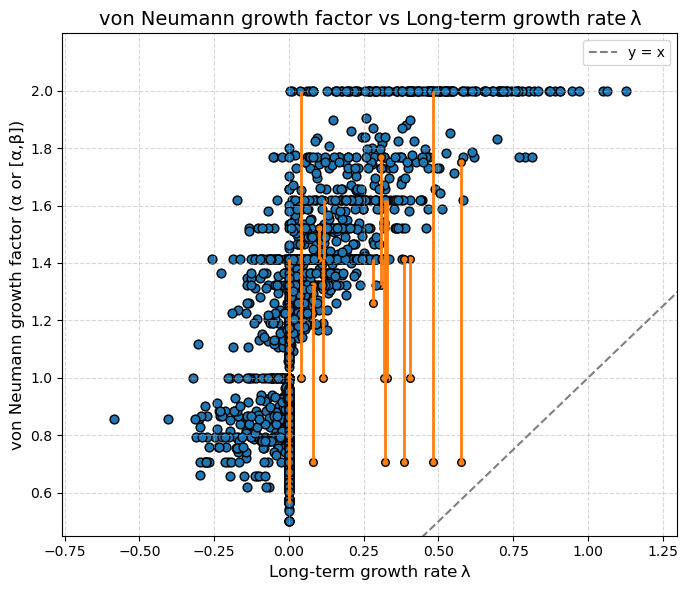

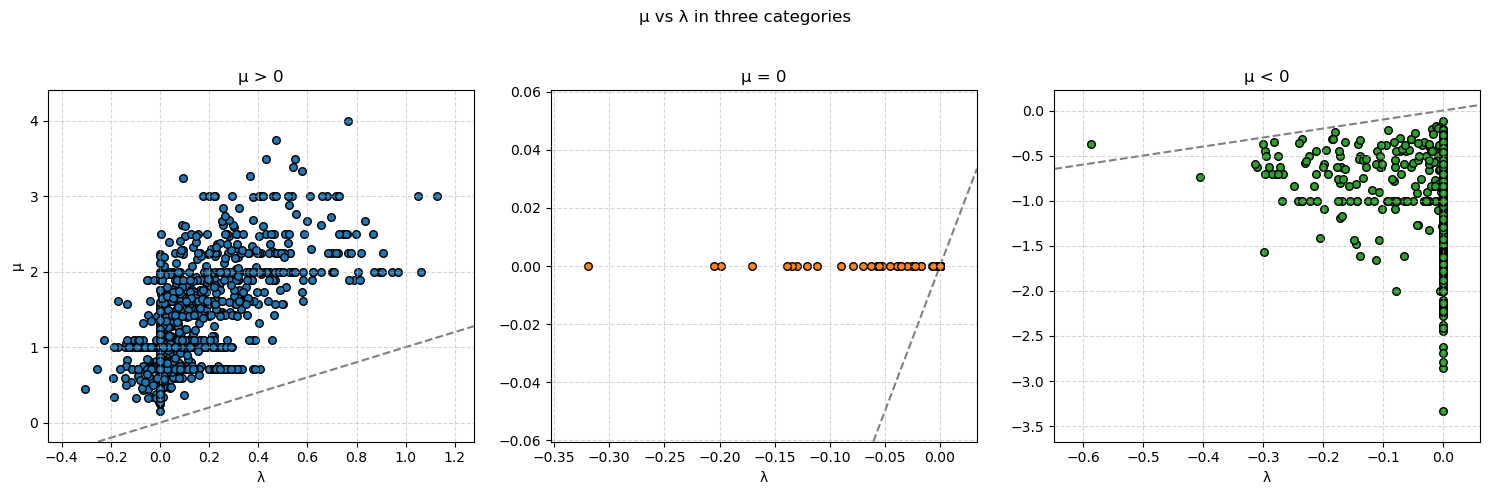

In [91]:
if __name__ == "__main__":
    main_order2()

In [19]:
""""
Distribution of random networks
"""
def main_order2_distribution():
    
    # storage
    alpha_list = []
    #beta_list = []
    #mu_list = []
    #S_plus_list = []
    #S_minus_list = []
    
    attempts = 0       
    successes = 0       
    target_num = 8000
    
    while successes < target_num and attempts < 80000:
        attempts += 1
        
        # Random networks
        Stot, N_Y, N_R, S_plus, S_minus = Generate_Random_Network(
        N_Y_raw=random.randint(2, 12),
        N_R_raw=random.randint(2, 12),
        ambiguity=False,
        max_order = 2
        )

        # Check autonomy condition
        _, _, auto = aux.checkAutonomy(S_minus, S_plus)
        if not auto:
            continue
         
        # von Neumann growth factor α
        try:
            alpha, beta, _, _, _, _ = compute_von_neumann_alpha_beta(S_plus, S_minus)
        except Exception:
            continue
        if np.isnan(alpha) or np.isnan(beta):
            continue

        '''
        mu = compute_topological_growth_bound(S_minus, alpha, x_alpha)
        
        if not np.isfinite(mu):
            continue
        '''

        # save
        alpha_list.append(alpha)
        #beta_list.append(beta)
        #mu_list.append(mu)
        #S_plus_list.append(S_plus)
        #S_minus_list.append(S_minus)
        
    alpha_arr = np.array(alpha_list)
    # Save raw alpha data
    np.save("alpha_values.npy", alpha_arr)
    
    '''
    # or to JSON
    with open("alpha_peaks.json", "w") as f:
        json.dump(peak_xs.tolist(), f)
    '''

    '''
    # smooth probability density curve of μ 
    mu_arr = np.array(mu_list)
    kde_mu  = gaussian_kde(mu_arr)
    x_mu    = np.linspace(mu_arr.min(), mu_arr.max(), 300)
    dens_mu = kde_mu(x_mu)
    
    idx_mu   = dens_mu.argmax()
    peak_x_mu, peak_y_mu = x_mu[idx_mu], dens_mu[idx_mu]
    
    plt.figure(figsize=(7, 6))
    plt.plot(x_mu, dens_mu, lw=2)
    plt.fill_between(x_mu, dens_mu, alpha=0.30)
    plt.plot([peak_x_mu, peak_x_mu], [0, peak_y_mu],
             ls='--', color='red', lw=1.5)
    plt.text(peak_x_mu, peak_y_mu,
             f"μ = {peak_x_mu:.3f}",
             color='red', fontsize=10, ha='center', va='bottom')
    
    plt.xlabel("Topological growth bound μ", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.title("Distribution of μ (KDE)", fontsize=14)
    plt.grid(linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()
    '''

    # 1) KDE on a fine grid
    kde = gaussian_kde(alpha_arr)
    x_min, x_max = 0, 2.5
    alpha_max = 2
    x_grid = np.linspace(x_min, alpha_max, 2000)
    dens = kde(x_grid)

    # find peaks in the density curve
    peaks_idx, _ = find_peaks(dens, distance=100)  
    # distance ensure that peaks are at least (distance) grid points apart.
    peak_xs = x_grid[peaks_idx]
    peak_ys = dens[peaks_idx]

    # Plot
    plt.figure(figsize=(8,5))
    '''
    # Optional: also show histogram with small bins
    plt.hist(alpha_arr, bins=100, density=True,
             color='C2', alpha=0.2, edgecolor='none')
    '''
    # KDE
    plt.plot(x_grid, dens, color='C2', lw=2)
    plt.fill_between(x_grid, dens, color='C2', alpha=0.3)

    # draw and label each peak
    for px, py in zip(peak_xs, peak_ys):
        plt.axvline(px, color='red', linestyle='--', lw=1)
        plt.text(px, py + 0.02, f"{px:.3f}",
                 color='red', fontsize=9,
                 ha='center', va='bottom')

    plt.xlim(x_min, x_max)
    plt.xlabel("von Neumann growth factor α", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.title("Distribution of α", fontsize=14)
    plt.grid(linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

    '''
    figure 2 with specific values
    '''
    plt.figure(figsize=(8,5))
    # KDE curve
    plt.plot(x_grid, dens, color='C2', lw=2)
    plt.fill_between(x_grid, dens, color='C2', alpha=0.3)
    
    # special alpha values (peaks)
    special_alphas = {
        r'$\frac{1}{\sqrt{2}}$': 1/np.sqrt(2),
        r'$1$': 1.0,
        r'$\sqrt[3]{2}$': 2**(1/3),
        r'$\sqrt{2}$': np.sqrt(2),
        r'$\frac{1+\sqrt{5}}{2}$': (1+np.sqrt(5))/2,
        r'$\sqrt{3}$': np.sqrt(3),
        r'$2$': 2.0
    }
    
    # draw lines
    for label, val in special_alphas.items():
    if x_min <= val <= alpha_max:
        ax.axvline(val, color='red', linestyle='--', lw=1)
        ax.text(
            val, 0, label,
            transform=ax.get_xaxis_transform(),
            ha='center', va='bottom',
            color='red', fontsize=10)
    
    plt.xlim(x_min, x_max)
    plt.xlabel("von Neumann growth factor α", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.title("Distribution of α", fontsize=14)
    plt.grid(linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

    # also expose them for downstream use
    return alpha_arr, peak_xs

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7096\4125688269.py:99: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  LB = fsolve(g, 2).item()  # Lower bound for α, β


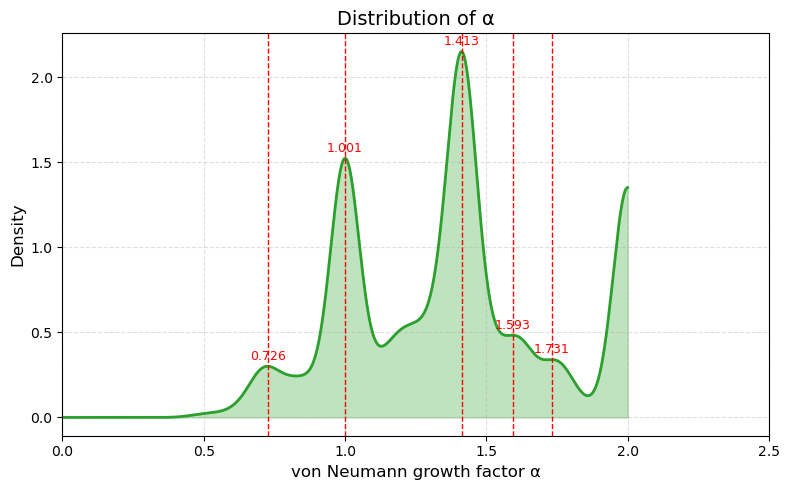

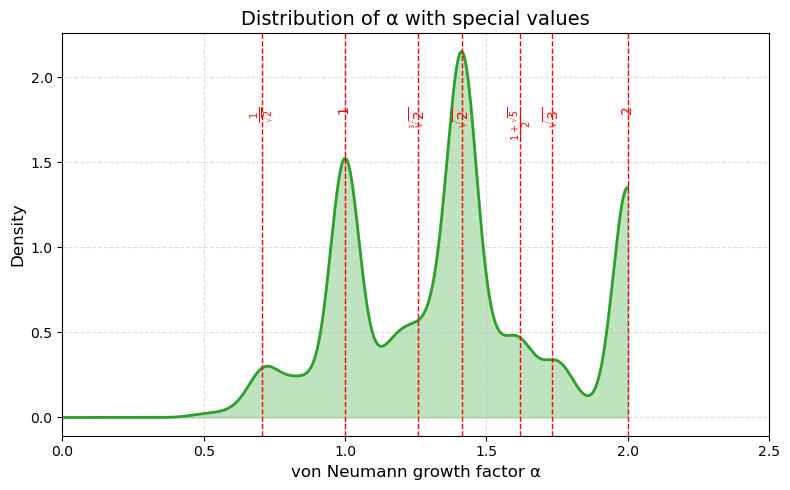

In [22]:
if __name__ == "__main__":
    main_order2_distribution()

In [92]:
'''
Stoichometric autocatalytic and dynamic growth

Systems for maximum chemical reaction order = 3

With autonomous check for matrix without X species
'''

def main_order3():

    # how many of each category
    quota_gt1  = 1000   # α > 1
    quota_eq1  = 100    # α = 1
    quota_lt1  = 1000   # α < 1

    # storage
    results_gt1 = []
    results_eq1 = []
    results_lt1 = []

    # counters
    count_gt1 = 0
    count_eq1 = 0
    count_lt1 = 0
    
    # storage
    alpha_list = []
    beta_list = []
    lambda_list = []
    mu_list = []
    growth_list = []
    S_plus_list = []
    S_minus_list = []
    kf_list = []; kd_list = []
    
    attempts = 0       
    successes = 0       
    
    # number of trail
    while attempts < 150000:
        attempts += 1
        
        # Random networks (change the oder here)
        Stot, N_Y, N_R, S_plus, S_minus = Generate_Random_Network(
        N_Y_raw=random.randint(3, 12),
        N_R_raw=random.randint(3, 12),
        ambiguity=False,
        max_order = 3
        )

        # Check autonomy condition
        _, _, auto = aux.checkAutonomy(S_minus, S_plus)
        if not auto:
            continue
         
        # von Neumann growth factor α, β
        try:
            alpha, beta, x_alpha, p_alpha, x_beta, p_beta = compute_von_neumann_alpha_beta(S_plus, S_minus)
        except Exception:
            continue
        if np.isnan(alpha) or np.isnan(beta):
            continue

        # check which quota this alpha would fill — skip if full
        if (alpha - 1) > 1e-6 and count_gt1 >= quota_gt1:
            continue
        if abs(alpha - 1) < 1e-6 and count_eq1 >= quota_eq1:
            continue
        if alpha < 1 and count_lt1 >= quota_lt1:
            continue
            
        mu = compute_topological_growth_bound(S_minus, alpha, x_alpha)
        if abs(mu) < 1e-3:
            mu = 0.0
        
        # Kinetics
        Y0, kf, kd = Construct_Kinetics(
            N_Y, N_R, S_plus, S_minus, degradation=False
        )
        
        try:
            q_star, lambda_long, J_star = solve_steadystate_by_newton_krylov(
                    S_plus, S_minus, N_Y, N_R, Y0, kf)
        
        except NoConvergence:        
            dt = 1e-4
            n_steps = 2000000
            threshold = 1e-4
            extra_steps = 100000
            t_eval, Ystar_traj, Yabs_traj, lambdas, N_traj = Solve_Scaled_System(
                S_minus, S_plus, Y0, N_Y, N_R,
                kf, kd, dt, n_steps, threshold, extra_steps, law = "MA")
            
            lambda_long = compute_long_term_growth_rate(lambdas)
        
        
        if not (np.isfinite(mu) and np.isfinite(lambda_long)):
            continue
            
        # save
        alpha_list.append(alpha)
        beta_list.append(beta)
        lambda_list.append(lambda_long)
        mu_list.append(mu)

        growth_list.append({
            'realization': successes,
            'alpha': alpha,
            'beta': beta,
            'mu': mu,
            'lambda': lambda_long
        })
        S_plus_list.append(S_plus)
        S_minus_list.append(S_minus)
        kf_list.append(kf)
        kd_list.append(kd)
                
        successes = len(alpha_list)
                
        if (alpha - 1) > 1e-3:
            count_gt1 += 1
        elif abs(alpha - 1) < 1e-3:
            count_eq1 += 1
        else:
            count_lt1 += 1
        
        print(f"【{successes}/{quota_gt1+quota_eq1+quota_lt1}】  α = {alpha:.5f},  β = {beta:.5f}, μ = {mu:.5f},  λ = {lambda_long:.5f}")
        
        if (count_gt1 >= quota_gt1 and
            count_eq1 >= quota_eq1 and
            count_lt1 >= quota_lt1):
            print("All quotas reached, stop simulation.")
            break
            
    # check loop        
        print(f"collect {successes} effective (α, β, mu, λ), end")
        
    if not (count_gt1 >= quota_gt1 and
            count_eq1 >= quota_eq1 and
            count_lt1 >= quota_lt1):
        print("\n can't reach goal")
        print(f"Tried {attempts} generation trials；")
        print(f"Collect α>1 Networks：{count_gt1} / {quota_gt1}")
        print(f"Collect α=1 Networks：{count_eq1} / {quota_eq1}")
        print(f"Collect α<1 Networks：{count_lt1} / {quota_lt1}\n")


    lam_arr = np.array(lambda_list)
    mu_arr = np.array(mu_list)
    
    plt.figure(figsize=(7, 6))
    
    y_lo = []
    y_hi = []
    for a, b in zip(alpha_list, beta_list):
        y_lo.append(min(a, b))
        y_hi.append(max(a, b))
        
    y_lo_arr = np.array(y_lo)
    y_hi_arr = np.array(y_hi)
    
    lam_min = lam_arr.min()
    lam_max = lam_arr.max()
    
    lam_range = lam_max - lam_min
    x_min = lam_min - 0.1 * lam_range
    x_max = lam_max + 0.1 * lam_range
    
    y_min = y_lo_arr.min() * 0.9
    y_max = y_hi_arr.max() * 1.1
        
    diag_min = min(x_min, y_min)
    diag_max = max(x_max, y_max)
    plt.plot([diag_min, diag_max], [diag_min, diag_max],
             ls='--', color='gray', label='y = x')
    
    for a, b, lam in zip(alpha_list, beta_list, lambda_list):
        if abs(a - b) < 1e-6:
            plt.scatter(lam, a, color='C0', edgecolors='k', s=40)
        else:
            lo = min(a, b)
            hi = max(a, b)
            plt.vlines(x=lam, ymin=lo, ymax=hi, color='C1', linewidth=2)
            plt.scatter([lam, lam], [lo, hi], color='C1', edgecolors='k', s=30)
    
    plt.xlabel("Long-term growth rate λ", fontsize=12)
    plt.ylabel("von Neumann growth factor (α or [α,β])", fontsize=12)
    plt.title("von Neumann growth factor vs Long-term growth rate λ", fontsize=14)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.legend()
    plt.grid(linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    mask_gt = mu_arr > 1e-3
    mask_eq = np.isclose(mu_arr, 0, atol=1e-3)
    mask_lt = mu_arr < -1e-3
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=False, sharey=False)
    
    for ax, (title, mask, color) in zip(axes, [
        ("μ > 0", mask_gt, "C0"),
        ("μ = 0", mask_eq, "C1"),
        ("μ < 0", mask_lt, "C2"),
    ]):
        lam_sub = lam_arr[mask]
        mu_sub  = mu_arr[mask]
    
        # Scatter plot, first let the axes auto-scale
        if lam_sub.size and mu_sub.size:
            ax.scatter(lam_sub, mu_sub, color=color, edgecolors='k', s=30)
        else:
            # If a certain category has no data points, draw an empty plot to maintain consistency.
            ax.plot([], [])
    
        # Get the current axis limits and add padding
        x0, x1 = ax.get_xlim()
        y0, y1 = ax.get_ylim()
        # 5% padding
        x_pad = 0.05 * (x1 - x0)
        y_pad = 0.05 * (y1 - y0)
        xmin = x0 - x_pad
        xmax = x1 + x_pad
        ymin = y0 - y_pad
        ymax = y1 + y_pad
    
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
    
        # x=y reference line only on [max(xmin,ymin), min(xmax,ymax)]
        d0 = max(xmin, ymin)
        d1 = min(xmax, ymax)
        ax.plot([d0, d1], [d0, d1], ls='--', color='gray', zorder=0)
    
        # polish
        ax.set_title(title)
        ax.set_xlabel("λ")
        ax.grid(linestyle="--", alpha=0.5)
        if title == "μ > 0":
            ax.set_ylabel("μ")
    
    plt.suptitle("μ vs λ in three categories")
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

    save_all_results(
        base_folder='results_order3',
        growth_list=growth_list,
        S_plus_list=S_plus_list,
        S_minus_list=S_minus_list,
        kf_list=kf_list,
        kd_list=kd_list)

D:\Anaconda\Lib\site-packages\scipy\optimize\_nonlin.py:374: RuntimeWarning: invalid value encountered in scalar divide
  and dx_norm/self.x_rtol <= x_norm))
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5008\4125688269.py:99: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  LB = fsolve(g, 2).item()  # Lower bound for α, β


【1/2100】  α = 1.87939,  β = 1.87939, μ = 1.87939,  λ = 0.58934
collect 1 effective (α, β, mu, λ), end
【2/2100】  α = 1.02491,  β = 1.02491, μ = 0.15453,  λ = -0.00000
collect 2 effective (α, β, mu, λ), end
【3/2100】  α = 0.50000,  β = 0.50000, μ = -2.50000,  λ = 0.00000
collect 3 effective (α, β, mu, λ), end
【4/2100】  α = 1.00000,  β = 1.00000, μ = 0.00000,  λ = -0.00000
collect 4 effective (α, β, mu, λ), end
【5/2100】  α = 2.04249,  β = 2.04249, μ = 2.74145,  λ = 0.25701
collect 5 effective (α, β, mu, λ), end
【6/2100】  α = 1.24143,  β = 1.24143, μ = 1.17760,  λ = 0.04077
collect 6 effective (α, β, mu, λ), end
【7/2100】  α = 0.88989,  β = 0.88989, μ = -0.77978,  λ = -0.00000
collect 7 effective (α, β, mu, λ), end
【8/2100】  α = 1.00000,  β = 1.00000, μ = 0.00000,  λ = -0.00536
collect 8 effective (α, β, mu, λ), end
【9/2100】  α = 0.61803,  β = 0.61803, μ = -2.00000,  λ = 0.00000
collect 9 effective (α, β, mu, λ), end
【10/2100】  α = 1.00000,  β = 1.00000, μ = 0.00000,  λ = 0.00000
collect 10 

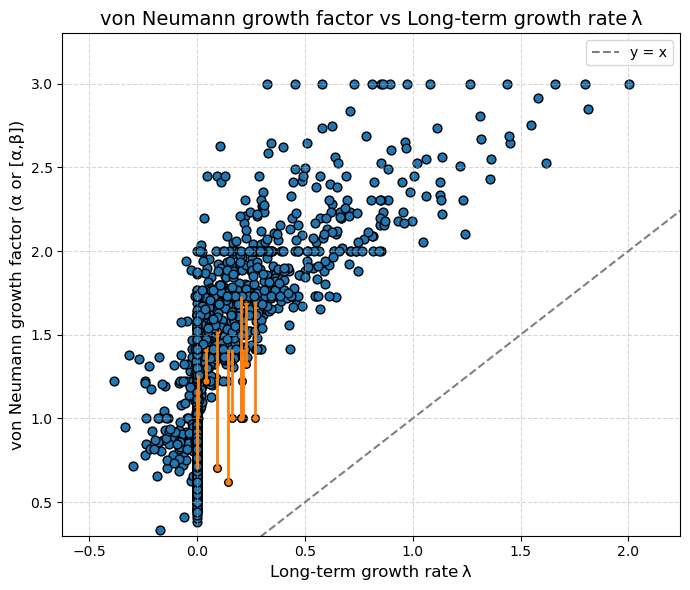

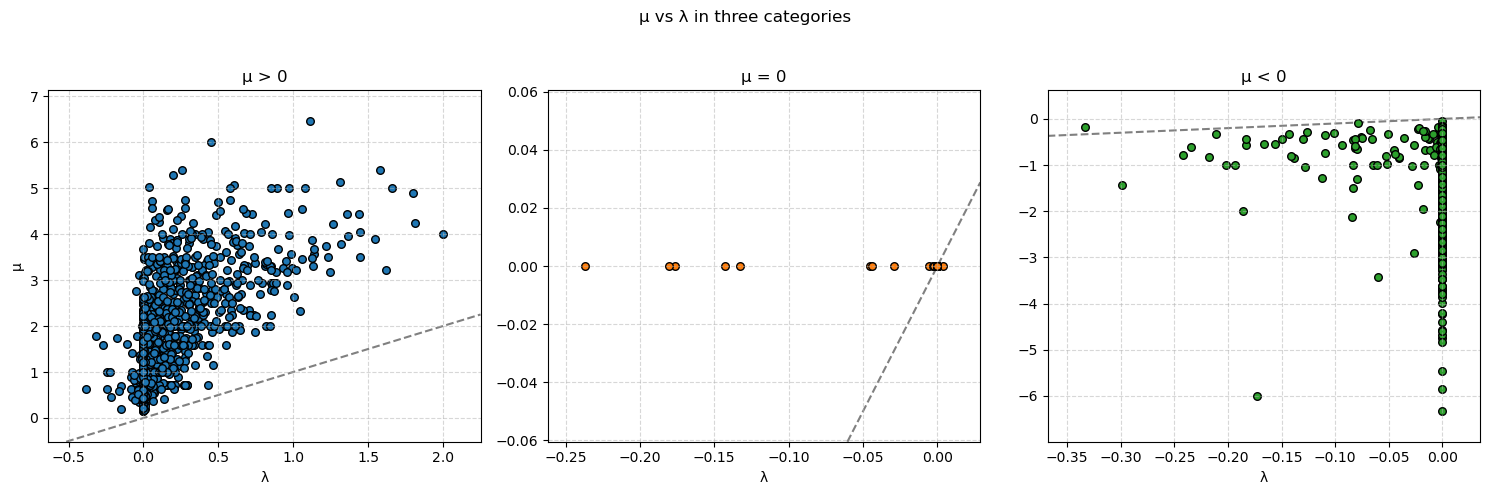

In [93]:
if __name__ == "__main__":
    main_order3()

In [94]:
""""
Distribution of random networks
"""
def main_order3_distribution():
    
    # storage
    alpha_list = []
    beta_list = []
    mu_list = []
    S_plus_list = []
    S_minus_list = []
    
    attempts = 0       
    successes = 0       
    target_num = 5000
    
    while successes < target_num and attempts < 50000:
        attempts += 1
        
        # Random networks
        Stot, N_Y, N_R, S_plus, S_minus = Generate_Random_Network(
        N_Y_raw=random.randint(3, 12),
        N_R_raw=random.randint(3, 12),
        ambiguity=False,
        max_order = 3
        )

        # Check autonomy condition
        _, _, auto = aux.checkAutonomy(S_minus, S_plus)
        if not auto:
            continue
         
        # von Neumann growth factor α, β
        try:
            alpha, beta, x_alpha, p_alpha, x_beta, p_beta = compute_von_neumann_alpha_beta(S_plus, S_minus)
        except Exception:
            continue
        if np.isnan(alpha) or np.isnan(beta):
            continue

        mu = compute_topological_growth_bound(S_minus, alpha, x_alpha)
        
        if not np.isfinite(mu):
            continue

        # save
        alpha_list.append(alpha)
        beta_list.append(beta)
        mu_list.append(mu)
        S_plus_list.append(S_plus)
        S_minus_list.append(S_minus)

    # smooth probability density curve of μ 
    mu_arr = np.array(mu_list)
    kde_mu  = gaussian_kde(mu_arr)
    x_mu    = np.linspace(mu_arr.min(), mu_arr.max(), 300)
    dens_mu = kde_mu(x_mu)
    
    idx_mu   = dens_mu.argmax()
    peak_x_mu, peak_y_mu = x_mu[idx_mu], dens_mu[idx_mu]
    
    plt.figure(figsize=(7, 6))
    plt.plot(x_mu, dens_mu, lw=2)
    plt.fill_between(x_mu, dens_mu, alpha=0.30)
    plt.plot([peak_x_mu, peak_x_mu], [0, peak_y_mu],
             ls='--', color='red', lw=1.5)
    plt.text(peak_x_mu, peak_y_mu,
             f"μ = {peak_x_mu:.3f}",
             color='red', fontsize=10, ha='center', va='bottom')
    
    plt.xlabel("Topological growth bound μ", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.title("Distribution of μ (KDE)", fontsize=14)
    plt.grid(linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    # smooth probability density curve of alpha
    alpha_arr = np.array(alpha_list)
    kde_a  = gaussian_kde(alpha_arr)
    x_a    = np.linspace(alpha_arr.min(), alpha_arr.max(), 300)
    dens_a = kde_a(x_a)
    
    idx_a   = dens_a.argmax()
    peak_x_a, peak_y_a = x_a[idx_a], dens_a[idx_a]
    
    plt.figure(figsize=(7, 6))
    plt.plot(x_a, dens_a, lw=2, color='C2')
    plt.fill_between(x_a, dens_a, alpha=0.30, color='C2')
    plt.plot([peak_x_a, peak_x_a], [0, peak_y_a],
             ls='--', color='red', lw=1.5)
    plt.text(peak_x_a, peak_y_a,
             f"α = {peak_x_a:.3f}",
             color='red', fontsize=10, ha='center', va='bottom')
    
    plt.xlabel("von Neumann growth factor α", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.title("Distribution of α (KDE)", fontsize=14)
    plt.grid(linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5008\4125688269.py:99: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  LB = fsolve(g, 2).item()  # Lower bound for α, β
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5008\4125688269.py:98: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  UB = fsolve(f, 1).item()  # Upper bound for α, β


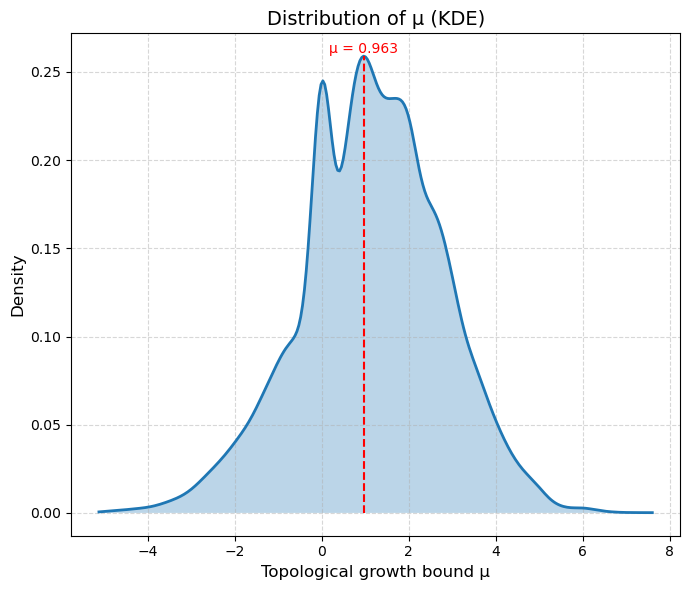

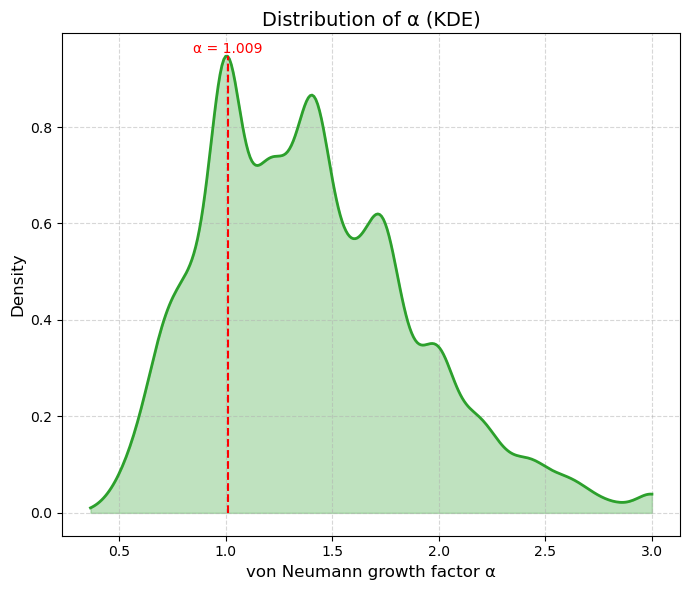

In [96]:
if __name__ == "__main__":
    main_order3_distribution()

In [28]:
""""
Distribution of random networks
"""
def main_order3_distribution():
    
    # storage
    alpha_list = []
    #beta_list = []
    #mu_list = []
    #S_plus_list = []
    #S_minus_list = []
    
    attempts = 0       
    successes = 0       
    target_num = 8000
    
    while successes < target_num and attempts < 80000:
        attempts += 1
        
        # Random networks
        Stot, N_Y, N_R, S_plus, S_minus = Generate_Random_Network(
        N_Y_raw=random.randint(2, 12),
        N_R_raw=random.randint(2, 12),
        ambiguity=False,
        max_order = 3
        )

        # Check autonomy condition
        _, _, auto = aux.checkAutonomy(S_minus, S_plus)
        if not auto:
            continue
         
        # von Neumann growth factor α
        try:
            alpha, beta, _, _, _, _ = compute_von_neumann_alpha_beta(S_plus, S_minus)
        except Exception:
            continue
        if np.isnan(alpha) or np.isnan(beta):
            continue

        '''
        mu = compute_topological_growth_bound(S_minus, alpha, x_alpha)
        
        if not np.isfinite(mu):
            continue
        '''

        # save
        alpha_list.append(alpha)
        #beta_list.append(beta)
        #mu_list.append(mu)
        #S_plus_list.append(S_plus)
        #S_minus_list.append(S_minus)
        
    alpha_arr = np.array(alpha_list)
    # Save raw alpha data
    np.save("alpha_values.npy", alpha_arr)
    
    '''
    # or to JSON
    with open("alpha_peaks.json", "w") as f:
        json.dump(peak_xs.tolist(), f)
    '''

    '''
    # smooth probability density curve of μ 
    mu_arr = np.array(mu_list)
    kde_mu  = gaussian_kde(mu_arr)
    x_mu    = np.linspace(mu_arr.min(), mu_arr.max(), 300)
    dens_mu = kde_mu(x_mu)
    
    idx_mu   = dens_mu.argmax()
    peak_x_mu, peak_y_mu = x_mu[idx_mu], dens_mu[idx_mu]
    
    plt.figure(figsize=(7, 6))
    plt.plot(x_mu, dens_mu, lw=2)
    plt.fill_between(x_mu, dens_mu, alpha=0.30)
    plt.plot([peak_x_mu, peak_x_mu], [0, peak_y_mu],
             ls='--', color='red', lw=1.5)
    plt.text(peak_x_mu, peak_y_mu,
             f"μ = {peak_x_mu:.3f}",
             color='red', fontsize=10, ha='center', va='bottom')
    
    plt.xlabel("Topological growth bound μ", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.title("Distribution of μ (KDE)", fontsize=14)
    plt.grid(linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()
    '''

    # 1) KDE on a fine grid
    kde = gaussian_kde(alpha_arr)
    x_min, x_max = 0, 3.5
    alpha_max = 3
    x_grid = np.linspace(x_min, alpha_max, 3000)
    dens = kde(x_grid)

    # find peaks in the density curve
    peaks_idx, _ = find_peaks(dens, distance=100)  
    # distance ensure that peaks are at least (distance) grid points apart.
    peak_xs = x_grid[peaks_idx]
    peak_ys = dens[peaks_idx]

    # Plot
    plt.figure(figsize=(8,5))
    '''
    # Optional: also show histogram with small bins
    plt.hist(alpha_arr, bins=100, density=True,
             color='C2', alpha=0.2, edgecolor='none')
    '''
    # KDE
    plt.plot(x_grid, dens, color='C2', lw=2)
    plt.fill_between(x_grid, dens, color='C2', alpha=0.3)

    # draw and label each peak
    for px, py in zip(peak_xs, peak_ys):
        plt.axvline(px, color='red', linestyle='--', lw=1)
        plt.text(px, py + 0.02, f"{px:.3f}",
                 color='red', fontsize=9,
                 ha='center', va='bottom')

    plt.xlim(x_min, x_max)
    plt.xlabel("von Neumann growth factor α", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.title("Distribution of α", fontsize=14)
    plt.grid(linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()



    # also expose them for downstream use
    return alpha_arr, peak_xs

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7096\4125688269.py:99: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  LB = fsolve(g, 2).item()  # Lower bound for α, β
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7096\4125688269.py:98: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  UB = fsolve(f, 1).item()  # Upper bound for α, β


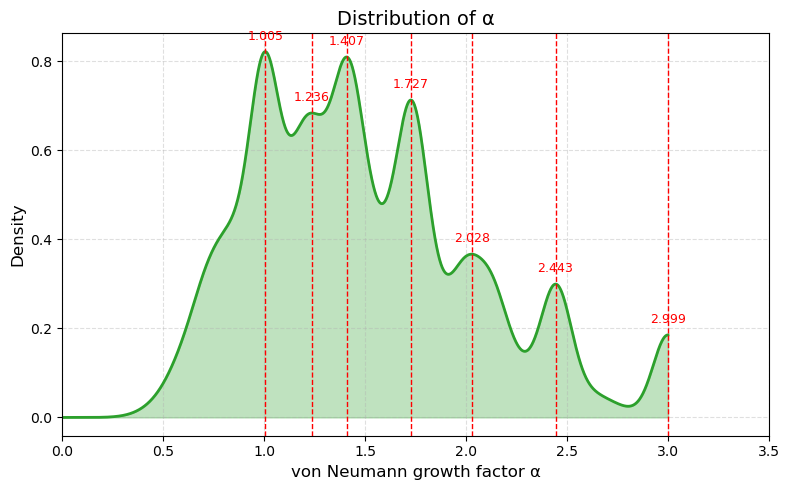

In [29]:
if __name__ == "__main__":
    main_order3_distribution()